### Load Library

In [1]:
!pip install torch transformers datasets scikit-learn tqdm peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import T5ForConditionalGeneration, T5Tokenizer,get_linear_schedule_with_warmup, T5EncoderModel
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

2025-05-05 05:30:42.424602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746423042.612927      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746423042.668950      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Dataset Loader

In [4]:
dataset = load_dataset("fancyzhx/amazon_polarity")

README.md:   0%|          | 0.00/6.81k [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

In [5]:
class AmazonPolarityDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item['content']
        label = item['label']

        # Tokenize text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [6]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [7]:
train_subset = dataset['train'].select(range(100000))  # Use 100k samples
test_subset = dataset['test'].select(range(20000))    # Use 20k samples


train_dataset = AmazonPolarityDataset(train_subset, tokenizer)
test_dataset = AmazonPolarityDataset(test_subset, tokenizer)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

### Model

In [8]:
class T5ClassifierWithLoRA(nn.Module):
    def __init__(self, model_name='t5-small', num_classes=2):
        super().__init__()

        # Load T5 encoder model (more efficient for classification tasks)
        self.t5 = T5EncoderModel.from_pretrained(model_name)

        # Configure LoRA
        peft_config = LoraConfig(
            task_type=TaskType.FEATURE_EXTRACTION,
            inference_mode=False,
            r=8,  # Rank of the low-rank matrices
            lora_alpha=32,  # Scaling factor
            lora_dropout=0.1,  # Dropout for LoRA layers
            target_modules=["q", "v"],  # Target attention modules
        )

        # Apply LoRA to the model
        self.t5 = get_peft_model(self.t5, peft_config)

        # Classification head (similar to BERT example)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(self.t5.config.d_model, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
        self.logsm = nn.LogSoftmax(dim=1)

        # Print trainable parameters
        self.t5.print_trainable_parameters()

    def forward(self, input_ids, attention_mask):
        # Get encoder outputs
        outputs = self.t5(input_ids=input_ids, attention_mask=attention_mask)

        # Get the last hidden states
        last_hidden_states = outputs.last_hidden_state

        # Apply mean pooling (taking the mean of all tokens)
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
        sum_embeddings = torch.sum(last_hidden_states * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_pooled = sum_embeddings / sum_mask

        # Pass through classifier
        x = self.dropout(mean_pooled)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return self.logsm(x)

In [9]:
model = T5ClassifierWithLoRA()
model.to(device)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

trainable params: 98,304 || all params: 35,429,120 || trainable%: 0.2775


T5ClassifierWithLoRA(
  (t5): PeftModelForFeatureExtraction(
    (base_model): LoraModel(
      (model): T5EncoderModel(
        (shared): Embedding(32128, 512)
        (encoder): T5Stack(
          (embed_tokens): Embedding(32128, 512)
          (block): ModuleList(
            (0): T5Block(
              (layer): ModuleList(
                (0): T5LayerSelfAttention(
                  (SelfAttention): T5Attention(
                    (q): lora.Linear(
                      (base_layer): Linear(in_features=512, out_features=512, bias=False)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0.1, inplace=False)
                      )
                      (lora_A): ModuleDict(
                        (default): Linear(in_features=512, out_features=8, bias=False)
                      )
                      (lora_B): ModuleDict(
                        (default): Linear(in_features=8, out_features=512, bias=False)
                      )
   

In [10]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    predictions = []
    actual_labels = []

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = nn.NLLLoss()(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)
        predictions.extend(preds.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})

    accuracy = accuracy_score(actual_labels, predictions)
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy

In [11]:
def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    actual_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = nn.NLLLoss()(outputs, labels)

            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(actual_labels, predictions)
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy, predictions, actual_labels

In [12]:
num_epochs = 5
learning_rate = 3e-4

optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=int(0.1 * total_steps),
                                            num_training_steps=total_steps)

In [13]:
def plot_training_history(train_losses, train_accs, val_losses, val_accs):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()


Epoch 1/5


Evaluating: 100%|██████████| 625/625 [01:22<00:00,  7.57it/s]


Train Loss: 0.2980, Train Acc: 0.8718
Val Loss: 0.2236, Val Acc: 0.9195

Epoch 2/5


Evaluating: 100%|██████████| 625/625 [01:22<00:00,  7.58it/s]


Train Loss: 0.2123, Train Acc: 0.9166
Val Loss: 0.1988, Val Acc: 0.9254

Epoch 3/5


Evaluating: 100%|██████████| 625/625 [01:22<00:00,  7.57it/s]


Train Loss: 0.1970, Train Acc: 0.9229
Val Loss: 0.1922, Val Acc: 0.9275

Epoch 4/5


Evaluating: 100%|██████████| 625/625 [01:22<00:00,  7.57it/s]


Train Loss: 0.1886, Train Acc: 0.9255
Val Loss: 0.1899, Val Acc: 0.9290

Epoch 5/5


Evaluating: 100%|██████████| 625/625 [01:22<00:00,  7.57it/s]


Train Loss: 0.1815, Train Acc: 0.9291
Val Loss: 0.1901, Val Acc: 0.9300


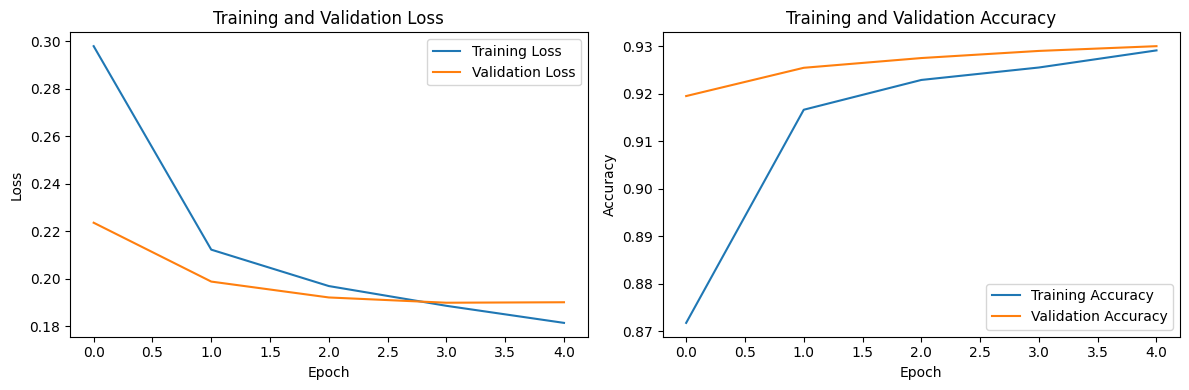

/tmp/ipykernel_19/1020520057.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
Evaluating: 100%|██████████| 625/625 [0


Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.94      0.93      9786
    Positive       0.94      0.93      0.93     10214

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



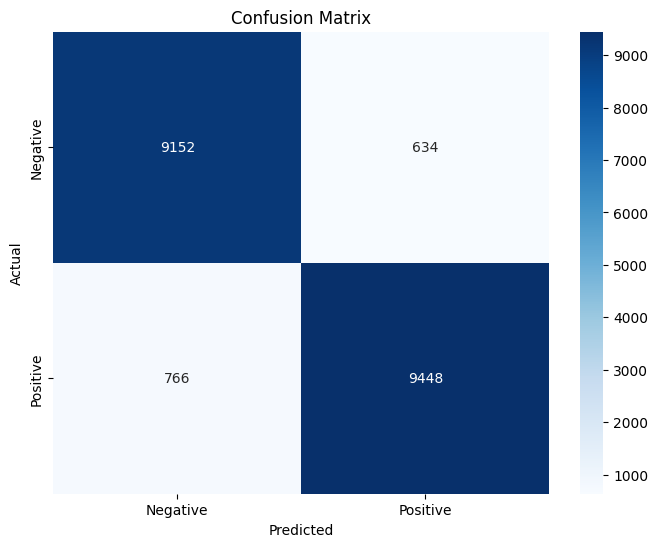

In [14]:
# Training loop
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train
    train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate
    val_loss, val_acc, predictions, actuals = evaluate(model, test_dataloader, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

# Plot training history
plot_training_history(train_losses, train_accs, val_losses, val_accs)

# Load best model and evaluate
model.load_state_dict(torch.load('best_model.pth'))
_, _, predictions, actuals = evaluate(model, test_dataloader, device)

# Print classification report
print("\nClassification Report:")
print(classification_report(actuals, predictions, target_names=['Negative', 'Positive']))

# Plot confusion matrix
plot_confusion_matrix(actuals, predictions, ['Negative', 'Positive'])